<a href="https://colab.research.google.com/github/pabloac31/TFG/blob/master/cifar10_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/pabloac31/TFG.git
%cd TFG

/content/TFG


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
from cifar10_models import *
from utils import *
from adversarial_attacks import *

In [0]:
iv3 = inception_v3(pretrained=True)

In [5]:
# Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [0]:
test_loader = testloader_cifar10('./data', 256, shuffle=False)

Files already downloaded and verified


In [0]:
test_model(iv3, device, test_loader)

100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


0.9541

In [6]:
adv_loader = testloader_cifar10('./data', 1)
univ_loader = testloader_cifar10('./data', 1, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
test_fgsm(iv3, device, './data/img1.png', 0.56)

  0%|          | 1/10000 [00:06<17:09:32,  6.18s/it]


======== RESULTS ========
Test Accuracy = 0 / 1 = 0.0
Average confidence = 0.7797232866287231
Average time = 5.761559963226318
Average magnitude of perturbations = 5.798830986022949
Model robustness = 0.07007209211587906


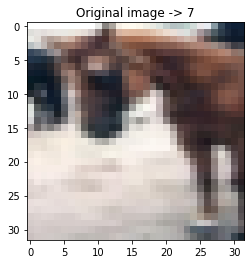

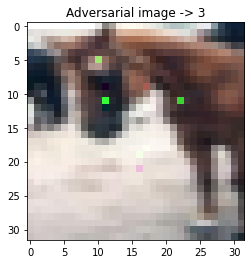

In [7]:
#params = {'epsilon': 0.4}
#params = {'num_classes': 10, 'overshoot': 0.02, 'max_iter': 50, 'lambda_fac': 1.0}
params = {'lambda_': 3., 'max_iter': 20, 'epsilon': 0.2, 'delta': 255}
adv_examples = attack_model(iv3, device, adv_loader, 'sparsefool', params, iters=1)

plt.imshow(denormalize_cifar10(adv_examples[0][2]).transpose((1,2,0)))
plt.title('Original image -> ' + str(adv_examples[0][0]))
plt.show()
plt.imshow(denormalize_cifar10(adv_examples[0][3]).transpose((1,2,0)))
plt.title('Adversarial image -> ' + str(adv_examples[0][1]))
plt.show()

In [0]:
v = universal_perturbation(univ_loader, iv3, device, delta=0.1)

plt.imshow(denormalize_cifar10(v[0].cpu().detach().numpy()).transpose((1,2,0)))
plt.title('Universal perturbation')
plt.show()

In [0]:
image = Image.open('./data/img1.png')
x = TF.to_tensor(image)
x = normalize_cifar10(x)
x = x.unsqueeze_(0).to(device)
label = torch.tensor([1]).to(device)
print('Label:', label.item())
x.requires_grad = True
y = iv3(x)
init_pred = y.max(1, keepdim=True)[1]
print("Original image prediction: ", init_pred.item())
x_r = x.add(v).to(device)
pred = iv3(x_r).max(1, keepdim=True)[1]
print("Perturbed image prediction: ", pred.item())

Label: 1
Original image prediction:  1
Perturbed image prediction:  2


In [0]:
def perturb(p, img):
  # Elements of p should be in range [0,1]
  img_size = img.size(2)  # H (= W)
  p_img = img.clone()
  xy = (p[0:2].copy() * img_size).astype(int)  # pixel x-y coordinates
  xy = np.clip(xy, 0, img_size-1)
  rgb = normalize_cifar10(p[2:5]).copy()
  rgb = clip_image_values(torch.from_numpy(rgb), normalize_cifar10(torch.tensor([0.,0.,0.], dtype=torch.double)), normalize_cifar10(torch.tensor([1.,1.,1.], dtype=torch.double)))
  p_img[0,:,xy[0],xy[1]] = rgb
  return p_img

In [0]:
def evaluate(model, device, candidates, img, label):
  preds = []
  model = model.to(device).eval()
  with torch.no_grad():
    for i, xs in enumerate(candidates):
      p_img = perturb(xs, img).to(device)
      preds.append(F.softmax(model(p_img).squeeze(), dim=0)[label].item())
  return np.array(preds)

In [0]:
def evolve(candidates, F=0.5, strategy="clip"):
  gen2 = candidates.copy()
  num_candidates = len(candidates)
  for i in range(num_candidates):
    x1, x2, x3 = candidates[np.random.choice(num_candidates, 3, replace=False)]
    x_next = (x1 + F * (x2 - x3))
    if strategy == "clip":
        gen2[i] = np.clip(x_next, 0, 1)
    elif strategy == "resample":
        x_oob = np.logical_or((x_next < 0), (1 < x_next))
        x_next[x_oob] = np.random.random(5)[x_oob]
        gen2[i] = x_next
  return gen2

In [0]:
def one_pixel_attack(model, device, img, label, target_label=None, iters=100, pop_size=400, verbose=True):
  # Targeted: maximize target_label if given (early stop > 50%)
  # Untargeted: minimize true_label otherwise (early stop < 5%)
  candidates = np.random.random((pop_size,5))
  candidates[:,2:5] = np.clip(np.random.normal(0.5, 0.5, (pop_size, 3)), 0, 1)
  is_targeted = target_label is not None
  label = target_label if is_targeted else label
  fitness = evaluate(model, device, candidates, img, label)
  
  def is_success():
      return (is_targeted and fitness.max() > 0.5) or ((not is_targeted) and fitness.min() < 0.05)
  
  for iteration in range(iters):
      # Early Stopping
      if is_success():
          break
      if verbose and iteration%1 == 0: # Print progress
          print("Target Probability [Iteration {}]:".format(iteration), fitness.max() if is_targeted else fitness.min())
      # Generate new candidate solutions
      new_gen_candidates = evolve(candidates, strategy="resample")
      # Evaluate new solutions
      new_gen_fitness = evaluate(model, device, new_gen_candidates, img, label)
      # Replace old solutions with new ones where they are better
      successors = new_gen_fitness > fitness if is_targeted else new_gen_fitness < fitness
      candidates[successors] = new_gen_candidates[successors]
      fitness[successors] = new_gen_fitness[successors]
  best_idx = fitness.argmax() if is_targeted else fitness.argmin()
  best_solution = candidates[best_idx]
  best_score = fitness[best_idx]

  return is_success(), best_solution, best_score


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


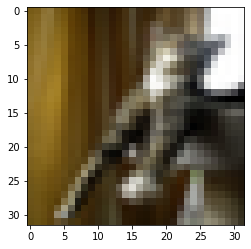

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True
0.012006991542875767


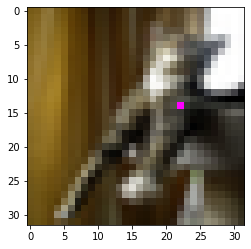

In [54]:
img, label = next(iter(adv_loader))
im = denormalize_cifar10(img.numpy()[0].copy()).transpose((1,2,0))
plt.imshow(im)
plt.show()
label = label.item()
success, sol, score = one_pixel_attack(iv3, device, img, label, pop_size=400, iters=20)
print(success)
print(score)
adv = perturb(sol, img)
im = denormalize_cifar10(adv.numpy()[0].copy()).transpose((1,2,0))
plt.imshow(im)
plt.show()